In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import re
import tensorflow as tf
from tensorflow.keras import layers
sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize




2023-05-23 08:59:36.211819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df1 = pd.read_csv("flight_LAX_ATL_data_0601_0831.csv")
print(f"{df1['From'][0]} => {df1['Destination'][0]} has {df1.shape[0]} flights from June 01 to August 31")
df1

LAX => ATL has 34814 flights from June 01 to August 31


,Price,Company Name,Stops,Duration,Destination,From,Date
0,254,American Airlines,nonstop,4h 38m,ATL,LAX,6/1/23
1,73,Spirit Airlines,1 stop,25h 28m,ATL,LAX,6/1/23
2,209,American Airlines,1 stop,6h 15m,ATL,LAX,6/1/23
3,159,United Airlines,1 stop,6h 55m,ATL,LAX,6/1/23
4,204,United Airlines,1 stop,6h 10m,ATL,LAX,6/1/23
...,...,...,...,...,...,...,...
34809,1174,"Avianca, JetBlue",3 stops,32h 56m,ATL,LAX,8/31/23
34810,1174,"Avianca, JetBlue",3 stops,37h 39m,ATL,LAX,8/31/23
34811,1201,"Avianca, JetBlue",3 stops,37h 39m,ATL,LAX,8/31/23
34812,1174,"Avianca, JetBlue",3 stops,38h 34m,ATL,LAX,8/31/23


In [3]:
def remove_outliers(df):
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    # Print the dropped values
    dropped_values = df[(df['Price'] < lower_lim) | (df['Price'] > upper_lim)]   
    # Remove the outliers
    df = df[(df['Price'] >= lower_lim) & (df['Price'] <= upper_lim)]
    return df

# convert duration to numerical format in minutes
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0])) 
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) 

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])
        
    return d

def clean_stops(stops):
    if stops == 'nonstop':
        return 0
    elif stops == '1 stop':
        return 1
    elif stops == '2 stops':
        return 2
    elif stops == '3 stops':
        return 3
    else:
        return np.nan

def get_avg_per_airline(x):
    # Average for trips with single airlines
    single_airlines = x[~x["Company Name"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Company Name", as_index=False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price": "Average Price"})
    temp = x.merge(avg_per_airline, on="Company Name", how="left")
    
    # Average for trips with multiple airlines
    multiple_airlines = x[x["Company Name"].str.contains(",")]
    avg_price_multiple = multiple_airlines["Price"].mean()
    multiple_airlines = multiple_airlines.reset_index(drop=True)  # Reset index
    temp.loc[multiple_airlines.index, "Average Price"] = avg_price_multiple
    
    return temp

def clean_date(date):
    date = pd.to_datetime(date)
    df1['Date'] = pd.to_datetime(df1['Date'])
    df1['DayOfWeek'] = (df1['Date'].dt.dayofweek + 1) % 7
    df1['Month'] = df1['Date'].dt.month
    return date

def clean_company_name(df1):
    # Remove leading and trailing whitespace
    df1['Company Name'] = df1['Company Name'].str.strip()
    # Remove punctuation
    df1['Company Name'] = df1['Company Name'].str.replace('[^\w\s]', '')
    # Remove extra whitespace within the company name
    df1['Company Name'] = df1['Company Name'].str.replace('\s+', ' ')
    return df1



In [4]:
df1['Duration'] = clean_duration(df1['Duration'])
df1['Date'] = clean_date(df1['Date'])
df1['Stops'] = df1['Stops'].apply(clean_stops).astype(float).fillna(-1).astype(int)
df1['Stops'] = df1['Stops'].replace(-1, '')
df1 = df1[df1['Stops'] != '']
df1 = get_avg_per_airline(df1)
df1=clean_company_name(df1)
df1 = remove_outliers(df1)

df1

/var/folders/16/21gn5t6x7f7dx4v5mtlkwz300000gn/T/ipykernel_42738/2339536939.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['Company Name'] = df1['Company Name'].str.replace('[^\w\s]', '')
/var/folders/16/21gn5t6x7f7dx4v5mtlkwz300000gn/T/ipykernel_42738/2339536939.py:69: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['Company Name'] = df1['Company Name'].str.replace('\s+', ' ')


,Price,Company Name,Stops,Duration,Destination,From,Date,DayOfWeek,Month,Average Price
0,254,American Airlines,0,278,ATL,LAX,2023-06-01,4,6,607.705316
1,73,Spirit Airlines,1,1528,ATL,LAX,2023-06-01,4,6,607.705316
2,209,American Airlines,1,375,ATL,LAX,2023-06-01,4,6,607.705316
3,159,United Airlines,1,415,ATL,LAX,2023-06-01,4,6,607.705316
4,204,United Airlines,1,370,ATL,LAX,2023-06-01,4,6,607.705316
...,...,...,...,...,...,...,...,...,...,...
34798,896,United Airlines,3,1806,ATL,LAX,2023-08-31,4,8,371.307490
34800,678,Avianca Frontier,3,2162,ATL,LAX,2023-08-31,4,8,NaN
34803,818,Avianca Frontier,3,2000,ATL,LAX,2023-08-31,4,8,NaN
34804,896,United Airlines,3,1961,ATL,LAX,2023-08-31,4,8,371.307490


In [8]:
def preprocess(df1):
    le = LabelEncoder()
    df1['Date'] = le.fit_transform(df1['Date'])
    df1['Company Name'] = le.fit_transform(df1['Company Name'])
preprocess(df1)
     

In [10]:
X = df1[['Date', 'Company Name', 'Stops', 'Duration', 'DayOfWeek', 'Month']]
X = np.array(X)
y = df1['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
X

array([[   0,    3,    0,  278,    4,    6],
       [   0,   11,    1, 1528,    4,    6],
       [   0,    3,    1,  375,    4,    6],
       ...,
       [  90,    4,    3, 2000,    4,    8],
       [  90,   16,    3, 1961,    4,    8],
       [  90,    4,    3, 2653,    4,    8]])

In [12]:
X_train.shape, y_train.shape

((27390, 6), (27390,))

In [15]:
model = tf.keras.models.Sequential([
    layers.Dense(500, activation = 'relu'),
    layers.Dropout(.2),
    layers.Dense(500, activation = 'relu'),
    layers.Dropout(.2),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(1)
])

In [16]:
model.compile(optimizer = 'adam', loss = 'huber')

In [17]:
history = model.fit(X_train, y_train, epochs = 20, verbose = 1, validation_split = .2)


Epoch 1/20
685/685 [==============================] - 4s 4ms/step - loss: 181.7896 - val_loss: 150.9944
Epoch 2/20
685/685 [==============================] - 2s 3ms/step - loss: 149.8848 - val_loss: 133.4330
Epoch 3/20
685/685 [==============================] - 2s 4ms/step - loss: 140.6858 - val_loss: 138.7754
Epoch 4/20
685/685 [==============================] - 3s 4ms/step - loss: 138.3451 - val_loss: 129.6251
Epoch 5/20
685/685 [==============================] - 3s 4ms/step - loss: 134.6061 - val_loss: 128.8900
Epoch 6/20
685/685 [==============================] - 3s 4ms/step - loss: 132.5349 - val_loss: 131.8038
Epoch 7/20
685/685 [==============================] - 3s 4ms/step - loss: 130.7329 - val_loss: 120.1748
Epoch 8/20
685/685 [==============================] - 3s 4ms/step - loss: 128.8357 - val_loss: 119.3852
Epoch 9/20
685/685 [==============================] - 3s 4ms/step - loss: 124.7348 - val_loss: 108.8529
Epoch 10/20
685/685 [==============================] - 3s 4ms/st

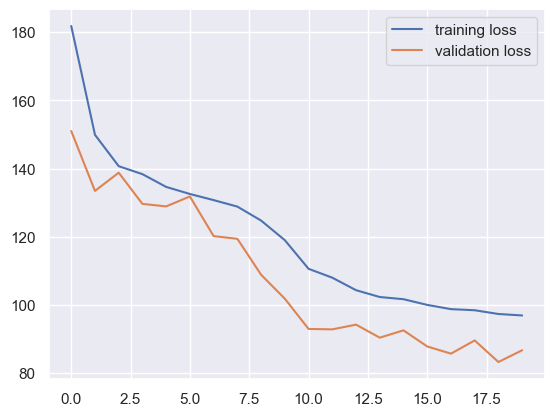

In [20]:
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

In [21]:
model.evaluate(X_test, y_test, verbose = 2)

214/214 - 0s - loss: 87.1378 - 339ms/epoch - 2ms/step


87.1378402709961

In [23]:
preds = model.predict(X_test)[:20]
preds = preds.flatten()
preds

214/214 [==============================] - 0s 1ms/step


array([661.1069 , 386.94003, 396.25266, 245.65813, 474.44058, 753.5105 ,
       382.28775, 858.33563, 343.22232, 411.1259 , 401.95053, 467.06094,
       279.20663, 325.36606, 261.71835, 753.7218 , 303.4824 , 411.52536,
       360.0828 , 398.94254], dtype=float32)

In [24]:
actual = np.array(y_test[:20])
actual

array([310, 309, 399, 229, 573, 713, 189, 843, 323, 392, 397, 628, 313,
       234, 602, 493, 400, 437, 309, 392])

In [25]:
preds - actual

array([ 351.10687256,   77.94003296,   -2.74734497,   16.65812683,
        -98.55941772,   40.51049805,  193.28775024,   15.33563232,
         20.22232056,   19.12588501,    4.95053101, -160.9390564 ,
        -33.79336548,   91.36605835, -340.28164673,  260.72180176,
        -96.51760864,  -25.47463989,   51.08279419,    6.9425354 ])

(array([ 583., 4072., 7796., 8164., 3759., 2836., 3201., 1254., 1724.,
         849.]),
 array([ 73. , 157.5, 242. , 326.5, 411. , 495.5, 580. , 664.5, 749. ,
        833.5, 918. ]),
 <BarContainer object of 10 artists>)

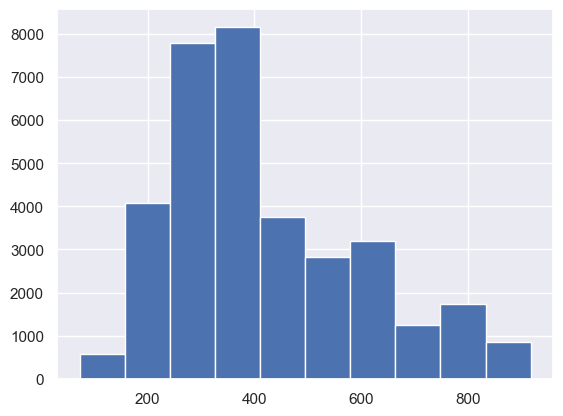

In [27]:
plt.hist(df1['Price'])

In [29]:
df1['Price'].min(), df1['Price'].max()

(73, 918)